
# Training a Classifier with Tensorboard

1. Import your libraries
2. Load the Dataset & Make the Dataset Iterable
3. Visualize the Data
4. Define the Network
5. Define Loss Function and Optimizer
6. Train the network
7. Save the model
8. Test the Network
9. Tensorboard


# Step 1:Import the libraries

In [1]:
# Imports
import torch
import torchvision
import torchvision.transforms as transforms

# Tensorboard - Writer will output to ./runs/ directory by default
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/CIFAR_Experiment_6')

# Load the TensorBoard notebook extension
%load_ext tensorboard

# check PyTorch versions
print(torch.__version__)
print(torchvision.__version__)

1.7.0+cu101
0.8.1+cu101


# Step 2:  Load the Dataset & Make the Dataset Iterable


In [2]:
# Define a transform to normalize the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # 3 channels (RGB) for colored images

# Download the training datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# Make the Dataset Iterable -change 8 instead of 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# Download the test datasets
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
# Make the Dataset Iterable
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Step 3: Visualize the Data

In [ ]:
# How long is the dataset
len(trainset)

50000

In [ ]:
# To access indivisual object from the dataset
sample = next(iter(trainset)) # train_set will produce 1 image
image, label= sample 
image.shape

torch.Size([3, 32, 32])

## Display a sample grid of images



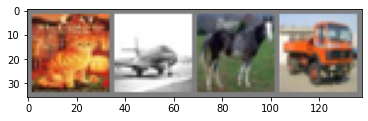

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# to get and show proper images
def show_img(img):
    # unnormalize the images
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    return npimg # return the unnormalized images

# get images 
dataiter = iter(trainloader)
images, labels = dataiter.next()
# create grid of images
img_grid = torchvision.utils.make_grid(images)
# get and show the unnormalized images
img_grid = show_img(img_grid)
# unnormalizing the images
img_grid = np.clip(img_grid, 0., 1.)
# write to tensorboard
writer.add_image('cifar10 images', img_grid)

# Step 4: Define the Network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# define net - Model
net = Net()

# Step 5: Define Loss Function and Optimizer



In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #try lr=0.002, lr=0.003

# Step 6: Train the network



In [ ]:
#add a neural network graph to TensorBoard
writer.add_graph(net, images)
writer.close()

In [ ]:
for epoch in range(10):  
    running_loss = 0.0
    running_correct = 0
    for data in (trainloader):
        # get the images and labels
        inputs, labels = data
        # set the parameter gradients to zero
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs.data, 1)
        loss.backward()
        # update the parameters
        optimizer.step()
        running_loss += loss.item()
        running_correct += (preds == labels).sum().item()
    # log the epoch loss
    writer.add_scalar('training loss',
                    running_loss/len(trainset),
                    epoch)
    # log the epoch accuracy
    writer.add_scalar('training accuracy',
                    running_correct/len(trainset),
                    epoch)
    
    print(f"Epoch {epoch+1} train loss: {running_loss/len(trainset):.3f} train acc: {running_correct/len(trainset)}")
print('Finished Training')

Epoch 1 train loss: 0.411 train acc: 0.39686
Epoch 2 train loss: 0.338 train acc: 0.51744
Epoch 3 train loss: 0.311 train acc: 0.56182
Epoch 4 train loss: 0.295 train acc: 0.58702
Epoch 5 train loss: 0.283 train acc: 0.60496
Epoch 6 train loss: 0.273 train acc: 0.61718
Epoch 7 train loss: 0.264 train acc: 0.6318
Epoch 8 train loss: 0.259 train acc: 0.63626
Epoch 9 train loss: 0.257 train acc: 0.64314
Epoch 10 train loss: 0.252 train acc: 0.65166
Finished Training


# Step 7: Save the model



In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# Step 8: Test the network on the test data



In [ ]:
# model testing
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

# percentage distributions, we will the add_histogram() function.
for i in range(10):
    writer.add_histogram('test accuracy per class', 100 * class_correct[i] / class_total[i], i)
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
writer.close()

Accuracy of plane : 76 %
Accuracy of   car : 75 %
Accuracy of  bird : 38 %
Accuracy of   cat : 35 %
Accuracy of  deer : 55 %
Accuracy of   dog : 53 %
Accuracy of  frog : 72 %
Accuracy of horse : 64 %
Accuracy of  ship : 61 %
Accuracy of truck : 58 %


# Step 9: Tensorboard


In [ ]:
# load tensorboard in this cell. Run this cell again to view new changes throughout the notebook.
%tensorboard --logdir=runs